<a href="https://www.kaggle.com/sdysch/tps-march-lag-feature-brt?scriptVersionId=89347282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Following on from https://www.kaggle.com/sdysch/eda-congestion-spikes-and-naive-predictions

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime as dt

In [18]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
df_train['time'] = pd.to_datetime(df_train['time'])

df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

In [19]:
def add_date_features(df):
    df['time']  = pd.to_datetime(df['time'])
    df['day']   = df['time'].dt.dayofweek
    df['month'] = df['time'].dt.month
    df['hour']  = df['time'].dt.hour
    return df

In [20]:
df_train = add_date_features(df_train)
df_test  = add_date_features(df_test)

In [21]:
def convert_road_coordinates(df):
    # REF: https://www.kaggle.com/inversion/tps-mar-22-cyclical-features
    from math import sin, cos, pi
    
    sin_vals = {
        'NB': 0.0,
        'NE': sin(1 * pi/4),
        'EB': 1.0,
        'SE': sin(3 * pi/4),
        'SB': 0.0,
        'SW': sin(5 * pi/4),    
        'WB': -1.0,    
        'NW': sin(7 * pi/4),  
    }

    cos_vals = {
        'NB': 1.0,
        'NE': cos(1 * pi/4),
        'EB': 0.0,
        'SE': cos(3 * pi/4),
        'SB': -1.0,
        'SW': cos(5 * pi/4),    
        'WB': 0.0,    
        'NW': cos(7 * pi/4),  
    }
    
    labels = {
        'NB': 1,
        'NE': 2,
        'EB': 3,
        'SE': 4,
        'SB': 5,
        'SW': 6,    
        'WB': 7,    
        'NW': 8,  
    }

    df['sin'] = df['direction'].map(sin_vals)
    #df['cos'] = df['direction'].map(cos_vals)
    #df['road_labels'] = df['direction'].map(labels)
    
    return df

In [22]:
df_train = convert_road_coordinates(df_train)
df_test  = convert_road_coordinates(df_test)

# Split train into train/validation to test a lagged feature model

In [23]:
training = df_train.copy(deep=True)
training.drop(['row_id'], axis=1, inplace=True)
print(training)

                      time  x  y direction  congestion  day  month  hour  \
0      1991-04-01 00:00:00  0  0        EB          70    0      4     0   
1      1991-04-01 00:00:00  0  0        NB          49    0      4     0   
2      1991-04-01 00:00:00  0  0        SB          24    0      4     0   
3      1991-04-01 00:00:00  0  1        EB          18    0      4     0   
4      1991-04-01 00:00:00  0  1        NB          60    0      4     0   
...                    ... .. ..       ...         ...  ...    ...   ...   
848830 1991-09-30 11:40:00  2  3        NB          54    0      9    11   
848831 1991-09-30 11:40:00  2  3        NE          28    0      9    11   
848832 1991-09-30 11:40:00  2  3        SB          68    0      9    11   
848833 1991-09-30 11:40:00  2  3        SW          17    0      9    11   
848834 1991-09-30 11:40:00  2  3        WB          24    0      9    11   

             sin  
0       1.000000  
1       0.000000  
2       0.000000  
3       1.0

In [24]:
print(training['x'].unique())
print(training['y'].unique())
print(training['direction'].unique())

[0 1 2]
[0 1 2 3]
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']


In [25]:
# create lagged congestion feature, there is probably a better way to do this
# unique x, y, direction pairings
x_unique         = training['x'].unique()
y_unique         = training['y'].unique()
direction_unique = training['direction'].unique()

lagged_dfs = []

for _x in x_unique:
    for _y in y_unique:
        for _direction in direction_unique:
            view = training[ (training['x'] == _x) & (training['y'] == _y) & (training['direction'] == _direction) ].copy(deep=True)
            view['congestion_lag'] = view['congestion'].shift(1)
            lagged_dfs.append(view)

In [26]:
# concat them all together
training = pd.concat(lagged_dfs)

# drop nans
training.dropna(inplace=True)
print(training)

                      time  x  y direction  congestion  day  month  hour  \
65     1991-04-01 00:20:00  0  0        EB          70    0      4     0   
130    1991-04-01 00:40:00  0  0        EB          70    0      4     0   
195    1991-04-01 01:00:00  0  0        EB          70    0      4     1   
260    1991-04-01 01:20:00  0  0        EB          70    0      4     1   
325    1991-04-01 01:40:00  0  0        EB          70    0      4     1   
...                    ... .. ..       ...         ...  ...    ...   ...   
848573 1991-09-30 10:20:00  2  3        SW          22    0      9    10   
848638 1991-09-30 10:40:00  2  3        SW          20    0      9    10   
848703 1991-09-30 11:00:00  2  3        SW          19    0      9    11   
848768 1991-09-30 11:20:00  2  3        SW          22    0      9    11   
848833 1991-09-30 11:40:00  2  3        SW          17    0      9    11   

             sin  congestion_lag  
65      1.000000            70.0  
130     1.000000 

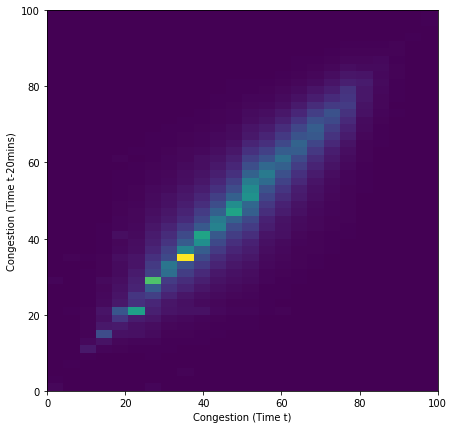

                congestion  congestion_lag
congestion        1.000000        0.811297
congestion_lag    0.811297        1.000000


In [27]:
# check correlations
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.hist2d(training['congestion'], training['congestion_lag'], bins=(24, 50))
ax.set_ylabel('Congestion (Time t-20mins)')
ax.set_xlabel('Congestion (Time t)')
plt.show()

print(training[['congestion', 'congestion_lag']].corr())

In [28]:
# dropping features
X = training.drop(['time', 'direction', 'month', 'congestion'], axis=1)
y = training['congestion']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print(X_train)

        x  y  day  hour  sin  congestion_lag
373808  2  2    3     3 -1.0             0.0
208552  1  2    2    18 -1.0            76.0
297990  1  2    0    21  0.0            69.0
653540  1  2    0     1  0.0            41.0
744430  2  1    5    16 -1.0            40.0
...    .. ..  ...   ...  ...             ...
720025  1  0    0    11  0.0            34.0
14003   1  2    2    23  0.0            37.0
87955   0  2    4    19 -1.0            40.0
337921  2  2    2    10  1.0            70.0
288414  0  2    5    20  0.0            62.0

[679016 rows x 6 columns]


# hyperparameter tuning

In [30]:
# defining search space
from hyperopt import hp
mln = [v + 1 for v in range(1, 20)]
mln.append(None)
print(mln)

params = {
    'n_estimators'   : hp.quniform('n_estimators', 50, 200, 25),
    'max_depth'      : hp.quniform('max_depth', 1, 20, 1),
    'max_leaf_nodes' : hp.choice('max_leaf_nodes', mln),
}

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None]


# Objective function

In [33]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hyperopt import STATUS_OK

def objective(params):
    global X_train, y_train, X_test, y_test
    
    params['n_estimators']   = int(params['n_estimators'])
    params['max_depth']      = int(params['max_depth'])
    
    if params['max_leaf_nodes'] is not None:
        params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    # fit model
    model = GradientBoostingRegressor(**params, random_state=42)
    #model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # make predictions with fitted model
    y_pred = model.predict(X_test)
    
    # return metrics
    return {
        'loss'     : mean_absolute_error(y_pred, y_test),
        'status'   : STATUS_OK,
        'RMSE'     : mean_squared_error(y_pred, y_test, squared=False)
        }

# Run trials

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(objective,
            space = params,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials,
           max_queue_len = 5)
print(best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]